# DSA4212 Assignment 3
**CAA: 8 April 2023**

## Setup

### Imports

In [1]:
!pip install jaxopt

import os
import sys
sys.setrecursionlimit(1005)

# Suppress warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as onp
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
from random import randint, random, shuffle, sample
from math import exp, hypot
from collections import defaultdict
import pandas as pd
import scipy as sp
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Data

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_3/

cities = onp.load('cities.npy', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataset/DSA4212/assignment_3


In [3]:
N, D = cities.shape
N, D

(1000, 2)

#### Create adjacency matrix

In [4]:
G = onp.array([[onp.linalg.norm(cities[i]-cities[j]) for j in range(len(cities))] for i in range(len(cities))])

### Utility Functions

In [75]:
def plot_tour(tour, C):
    tour = list(tour)
    plt.figure(figsize=(40, 15))
    plt.plot(*zip(*cities[tour+[tour[0]]]))
    plt.scatter(*zip(*cities), c='b')
    plt.scatter(*cities[0], c='r', s=100)
    plt.axis('off')
    plt.title(f'Cost: {C}', fontsize=20)
    plt.show()

In [76]:
def cost(tour, plot=True):
    C = sum(G[tour[i]][tour[(i+1)%N]] for i in range(N))
    if plot: plot_tour(tour, C)
    else: return C

## Greedy Approach (28.94)

Source: https://open.kattis.com/problems/tsp

In [7]:
def tsp_greedy(G):
    used = [0]*N
    tour = [0]
    used[0] = 1
    for i in range(1, N):
        best =  -1
        for j in range(N):
            if not used[j] and (best == -1 or G[tour[i-1]][j] < G[tour[i-1]][best]): best = j
        tour.append(best)
        used[best] = True
    return tour

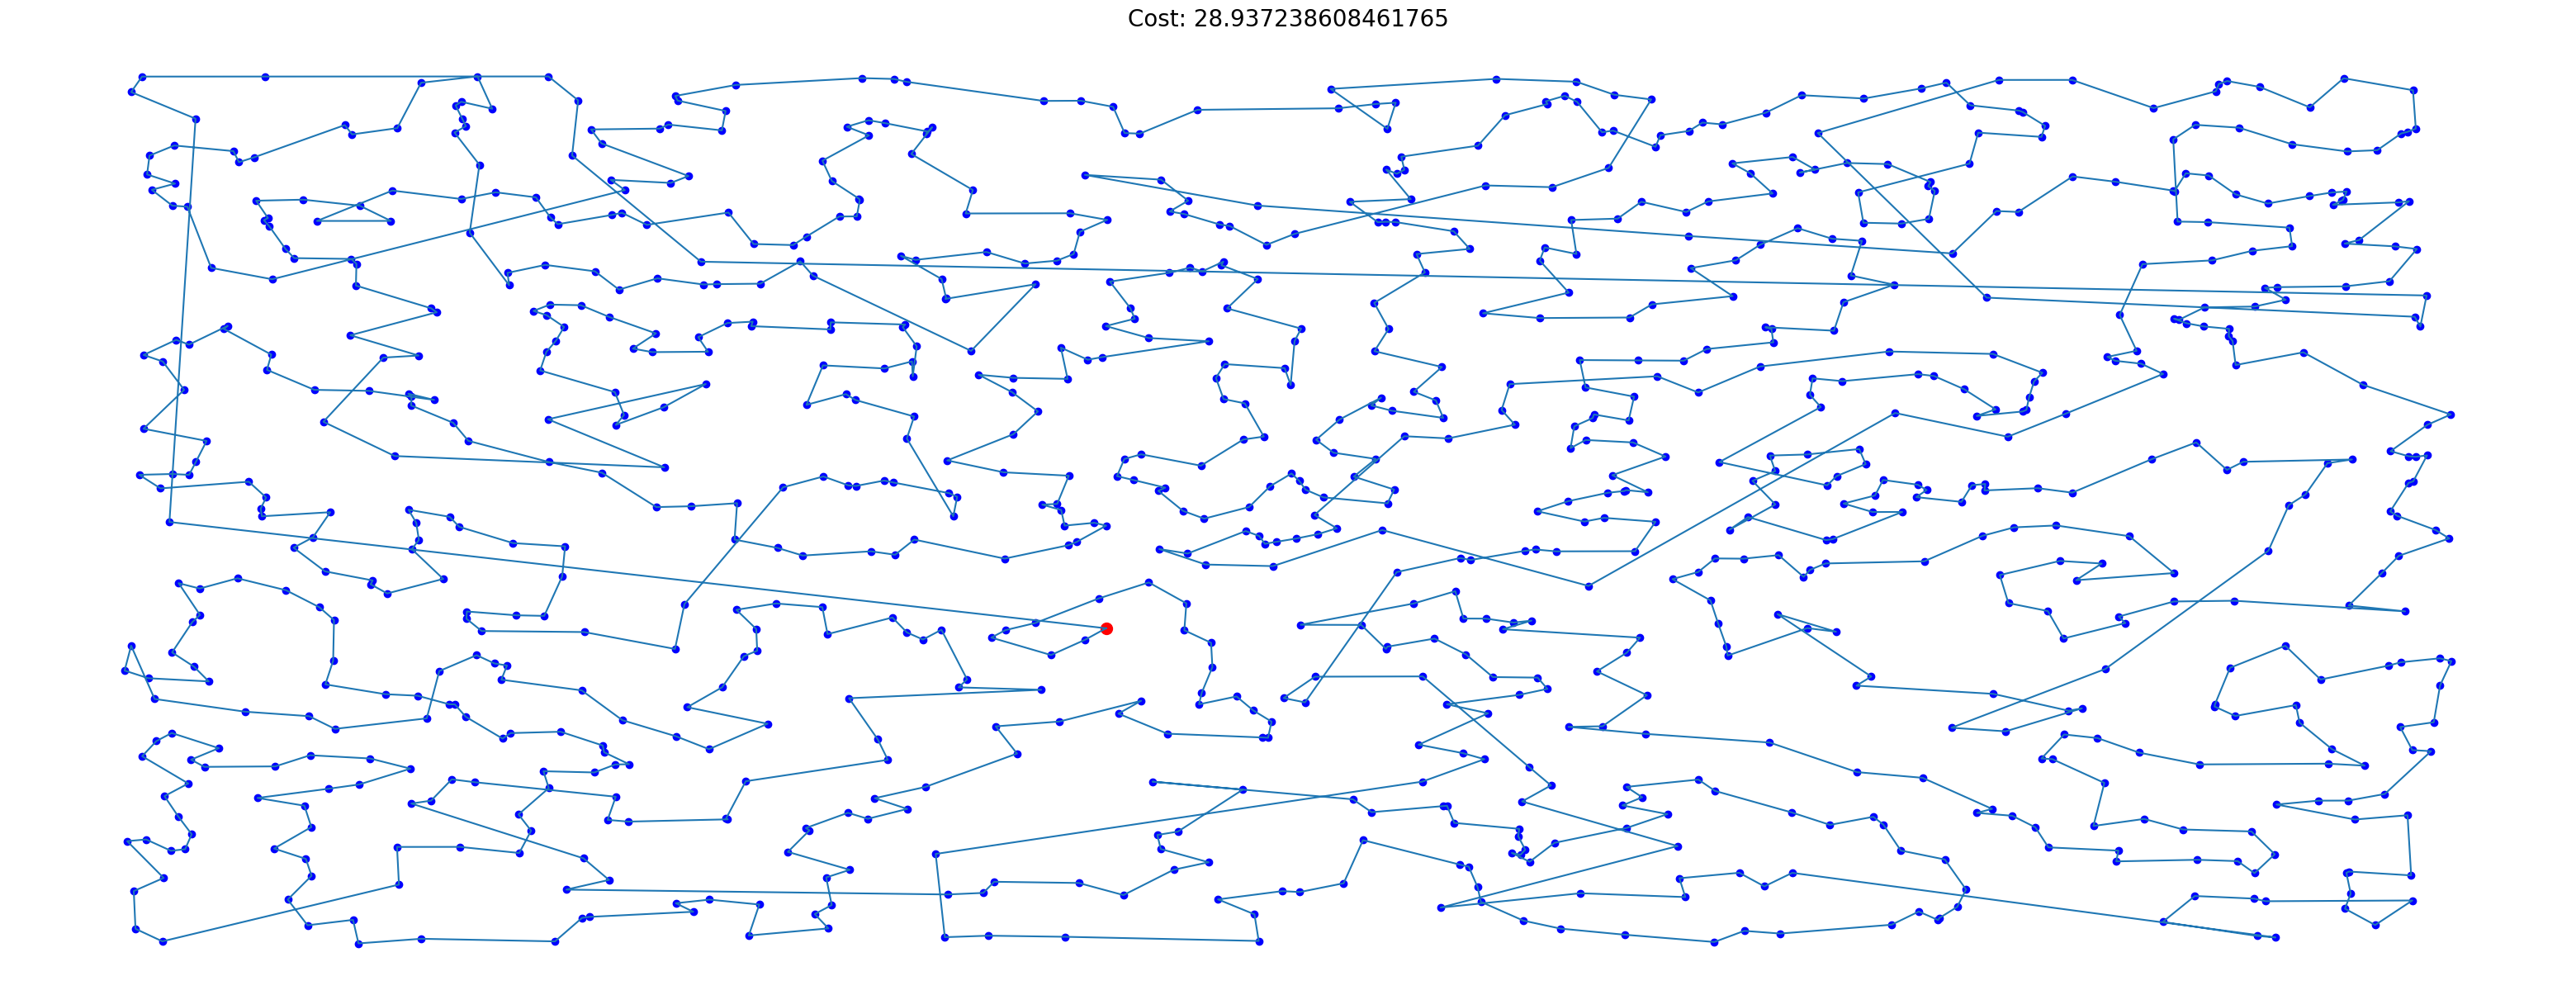

CPU times: user 1.44 s, sys: 88.4 ms, total: 1.52 s
Wall time: 3.77 s


In [8]:
%%time
cost(tsp_greedy(G))

## 2-Approximaton: MST (32.13)

Source: Original, Prim's Algorithm

In [9]:
def mst(G):
    st = []
    a, b = [(1e9, i) for i in range(N)], [1]*N
    a[0] = (0, 0)
    while len(st) != N:
        mi, mv = 0, a[0]
        for i in range(1, N):
            if a[i] < mv: mi, mv = i, a[i]
        st.append((mi, mv))
        a[mi], b[mi] = (1e9, mi), 0
        for w in range(N):
            if b[w] and a[w] > (G[mi][w], mi):
                a[w] = (G[mi][w], mi)
    g = [[] for _ in range(N)]
    for t in st[1:]: g[t[1][1]].append(t[0]), g[t[0]].append(t[1][1])
    return g

def tsp_mst(G):
    g = mst(G)
    sts = []
    def dfs(u):
        st.append(u)
        for i in g[u]:
            if i not in vis: vis.add(i), dfs(i)
    for i in range(N):
        st, vis = [], {i}
        dfs(i)
        sts.append(st)
    return min(sts, key=lambda x: cost(x, plot=False))

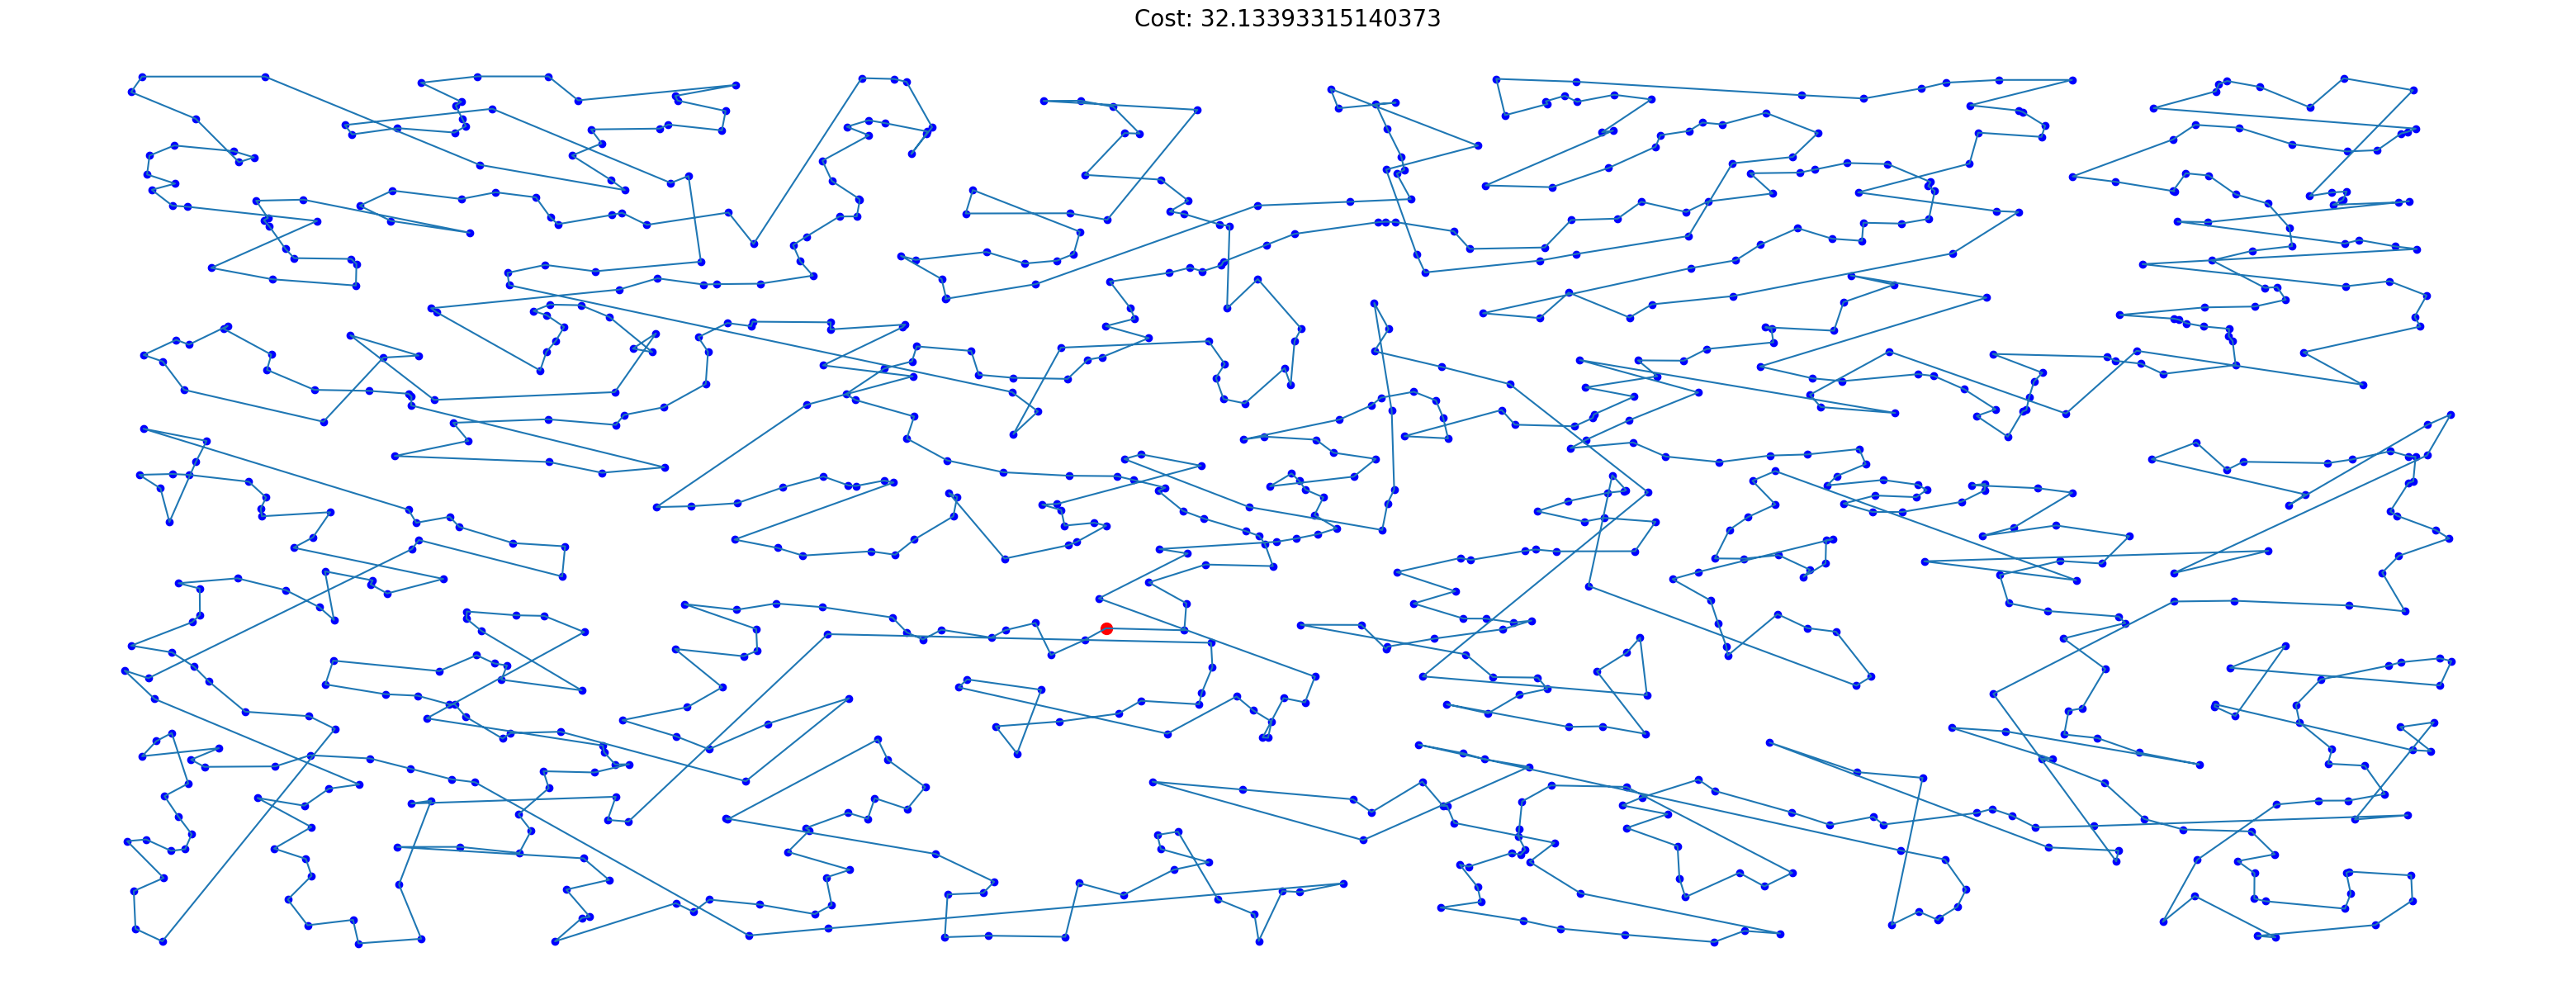

CPU times: user 3.01 s, sys: 86.5 ms, total: 3.1 s
Wall time: 4.68 s


In [10]:
%%time
cost(tsp_mst(G))

## Simulated Annealing (~29.4)

Source: https://sandipanweb.wordpress.com/2020/12/08/travelling-salesman-problem-tsp-with-python/

In [93]:
def swap(s, m, n):
    i, j = min(m, n), max(m, n)
    while i < j:
        s[i], s[j] = s[j], s[i]
        i += 1
        j -= 1

In [94]:
def tsp_sa(G, s=None, lim=1_000_000):
    if s == None: s = list(range(N))
    c = cost(s, plot=False)
    cost_history = [c]

    # hyperparameter
    T = 10_000_000
    alpha = 0.99

    for ntrial in tqdm(range(lim)):
        n = randint(0, N-1)
        while True:
            m = randint(0, N-1)
            if n != m: break
        swap(s, m, n)
        c1 = cost(s, plot=False)
        if c1 < c or random() < exp((c-c1)/T): c = c1
        else: swap(s, m, n)
        T = alpha*T
        cost_history.append(c)
    plt.plot(cost_history)
    plt.ylabel('TSP Cost')
    plt.xlabel('Iteration')
    plt.show()
    return s

  0%|          | 0/1000000 [00:00<?, ?it/s]

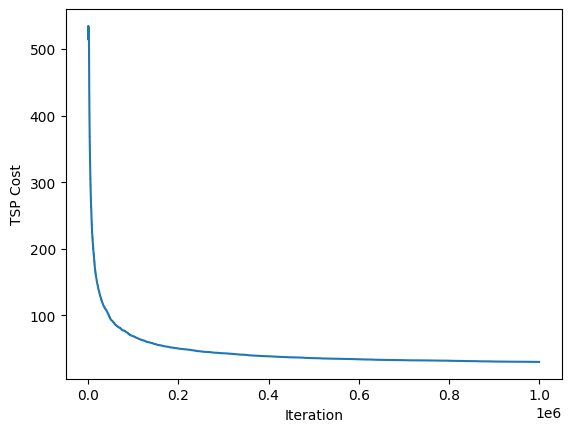

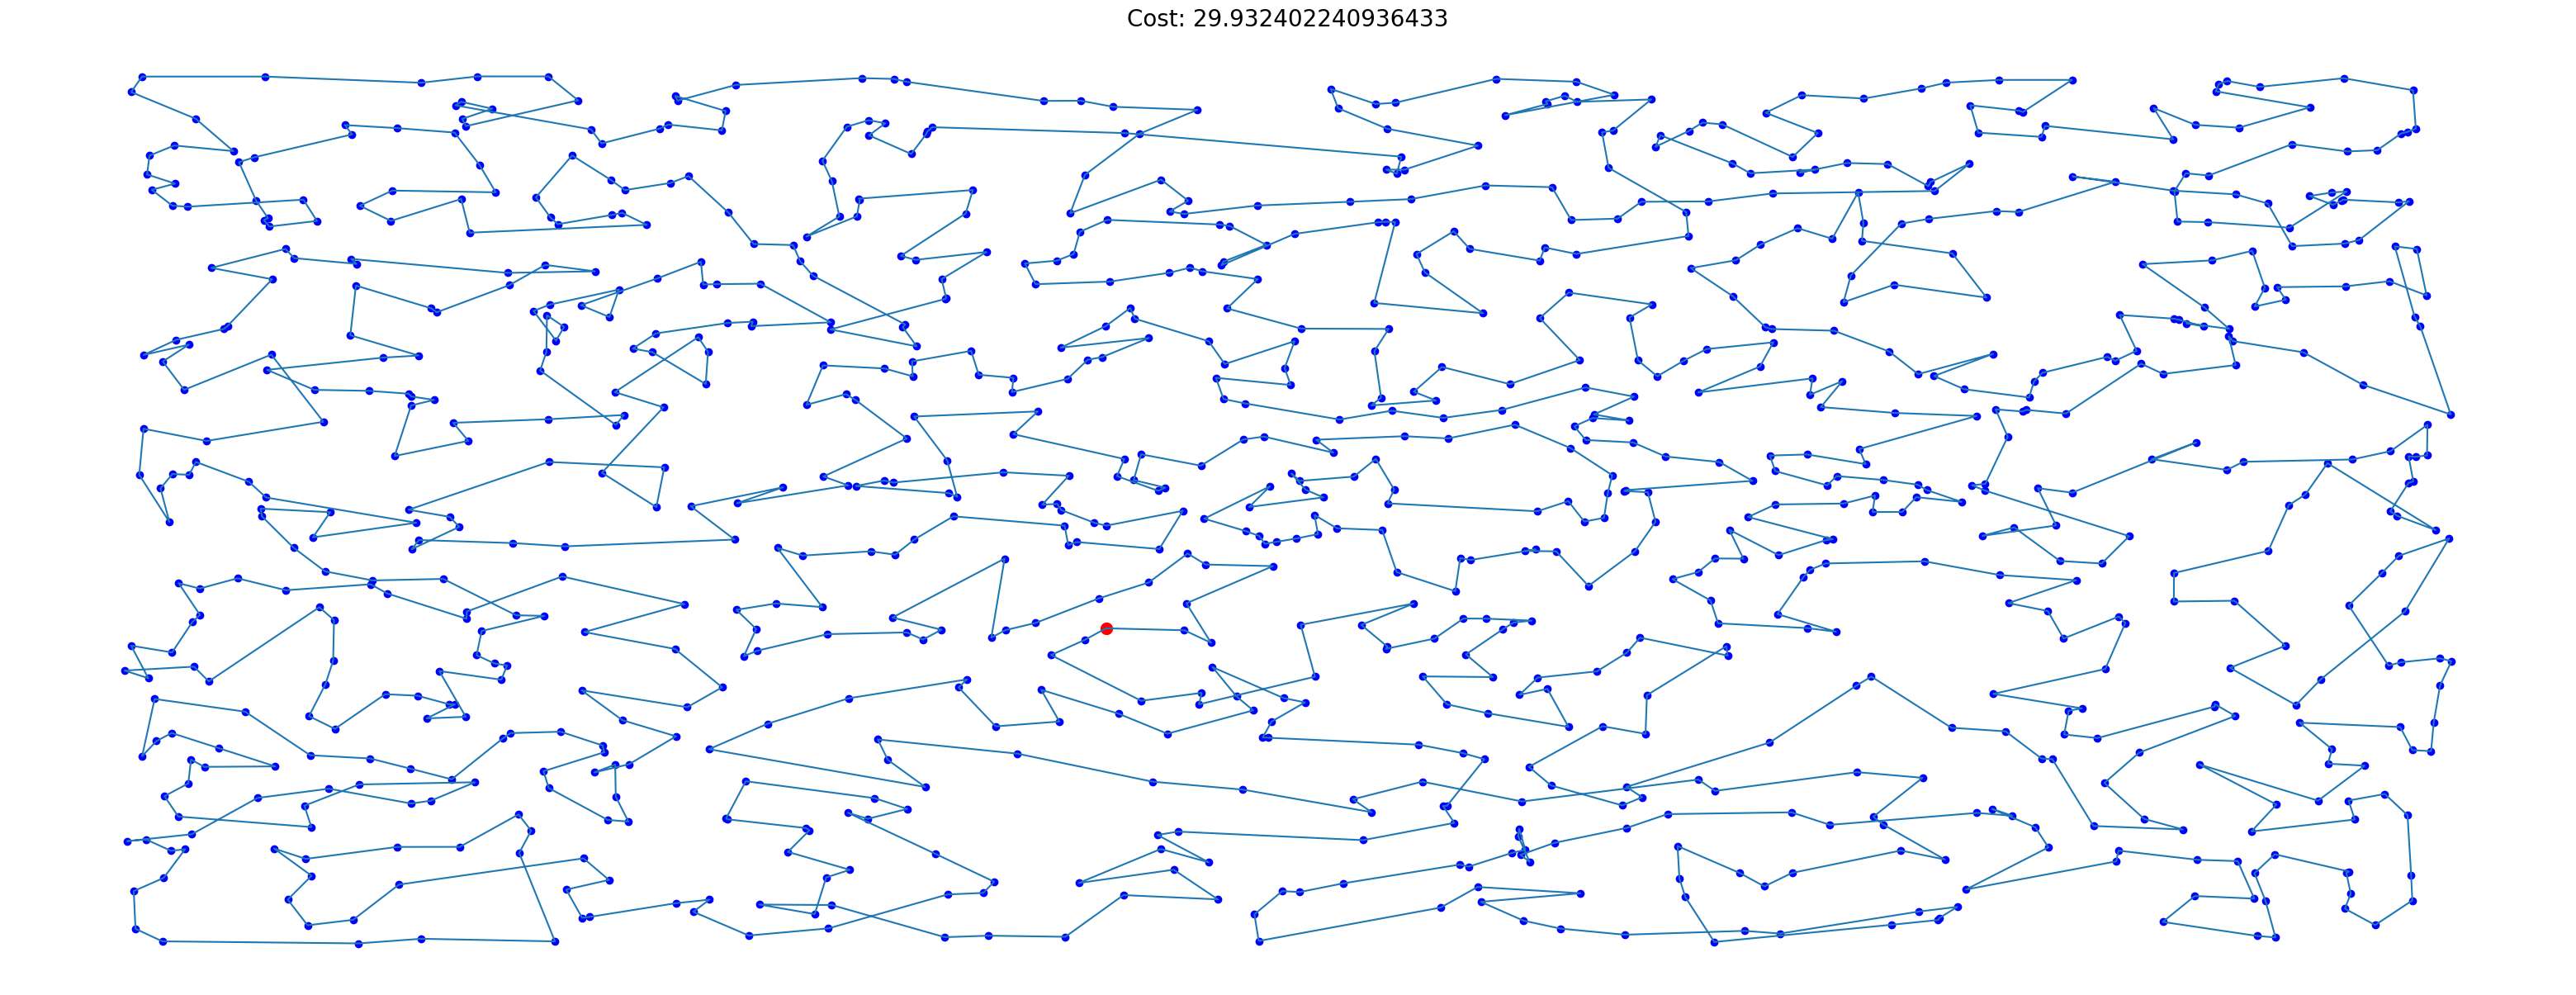

CPU times: user 11min 6s, sys: 4.36 s, total: 11min 11s
Wall time: 11min 41s


In [13]:
%%time
cost(tsp_sa(G))

  0%|          | 0/1000000 [00:00<?, ?it/s]

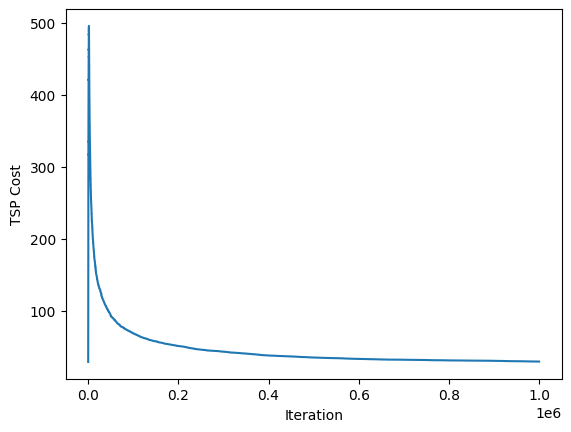

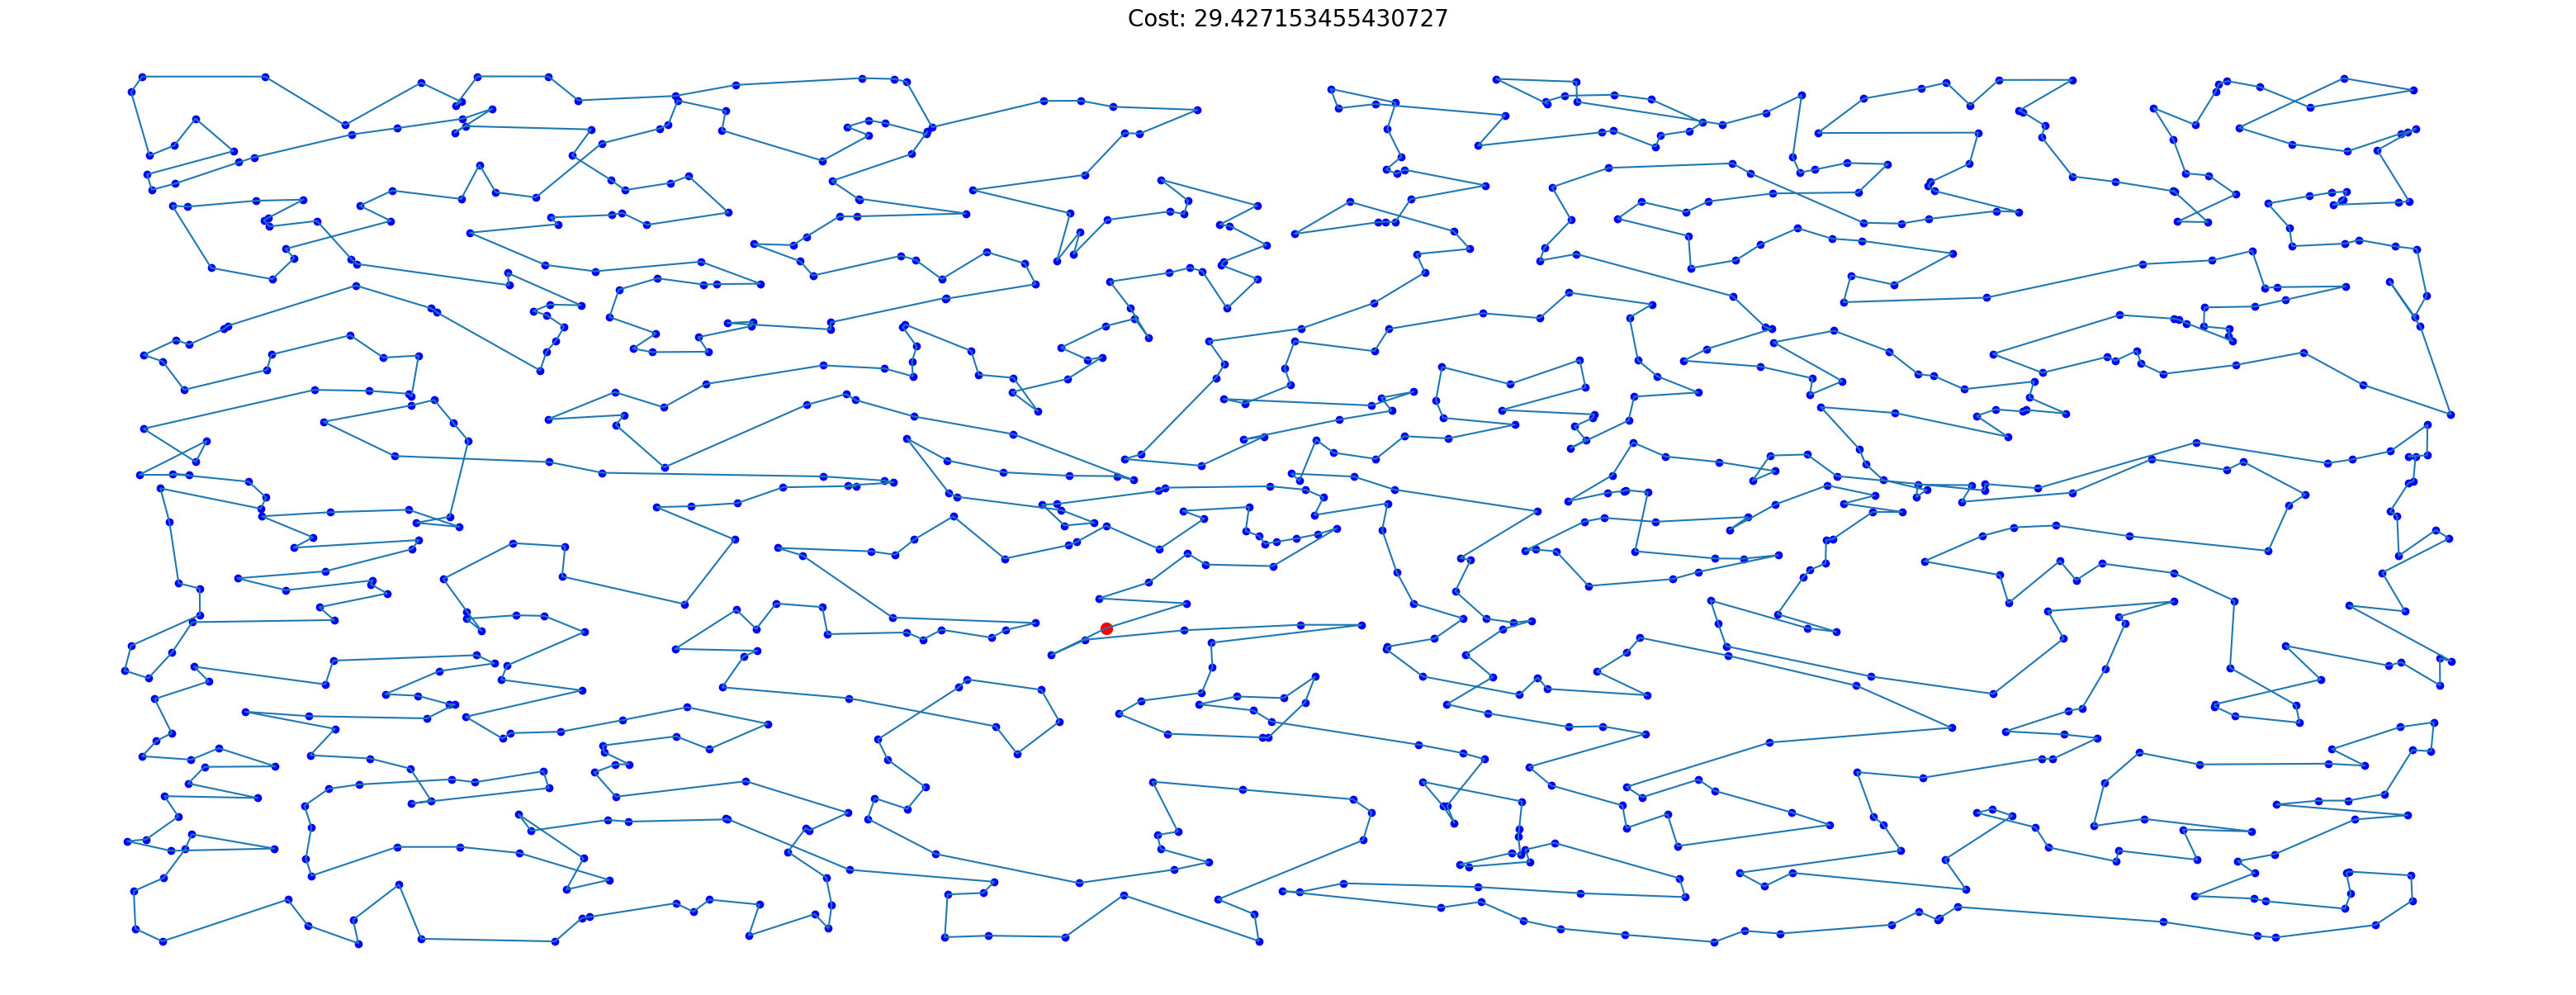

CPU times: user 11min 34s, sys: 4.43 s, total: 11min 38s
Wall time: 11min 59s


In [95]:
%%time
cost(tsp_sa(G, s=tsp_greedy(G)))

## 1.5-Approximation: NetworkX + Christofides (26.6)

Source: [NetworkX's Christofides Algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.traveling_salesman.christofides.html)

In [14]:
def tsp_christofides(G):
    nxG = nx.Graph()
    for i in range(N):
        for j in range(i+1, N):
            nxG.add_edge(i, j, weight=G[i][j])
    return nx.approximation.christofides(nxG)

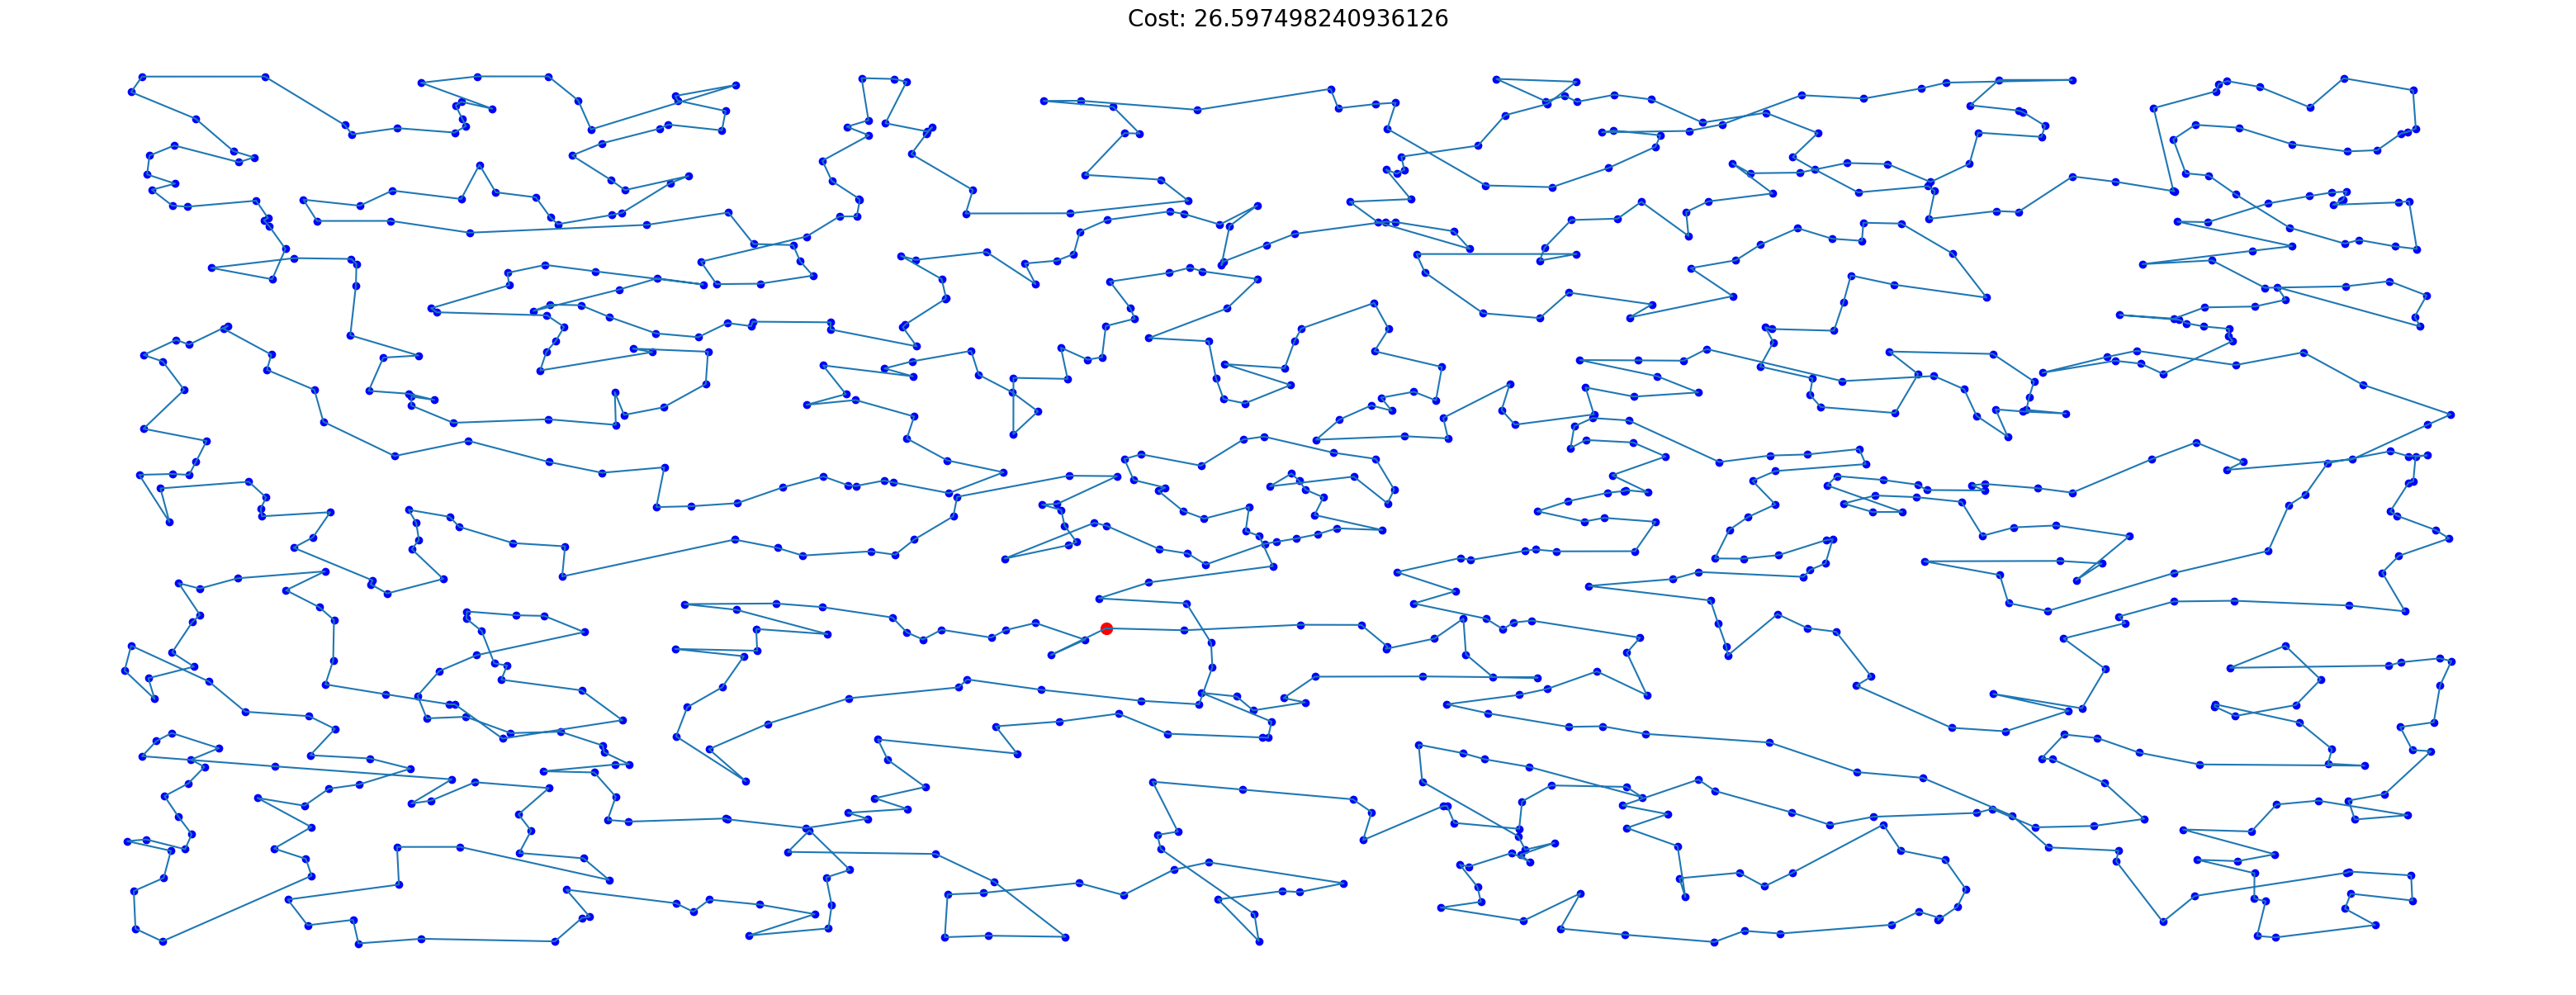

CPU times: user 1min 53s, sys: 914 ms, total: 1min 54s
Wall time: 1min 55s


In [15]:
%%time
christofides = tsp_christofides(G)
cost(christofides)

## k-opt heuristic, CPP (24.59)

Locally ran using C++ in about 5-20 seconds.

Source: https://github.com/ngamanda/Kattis-TSP/blob/master/main.cpp

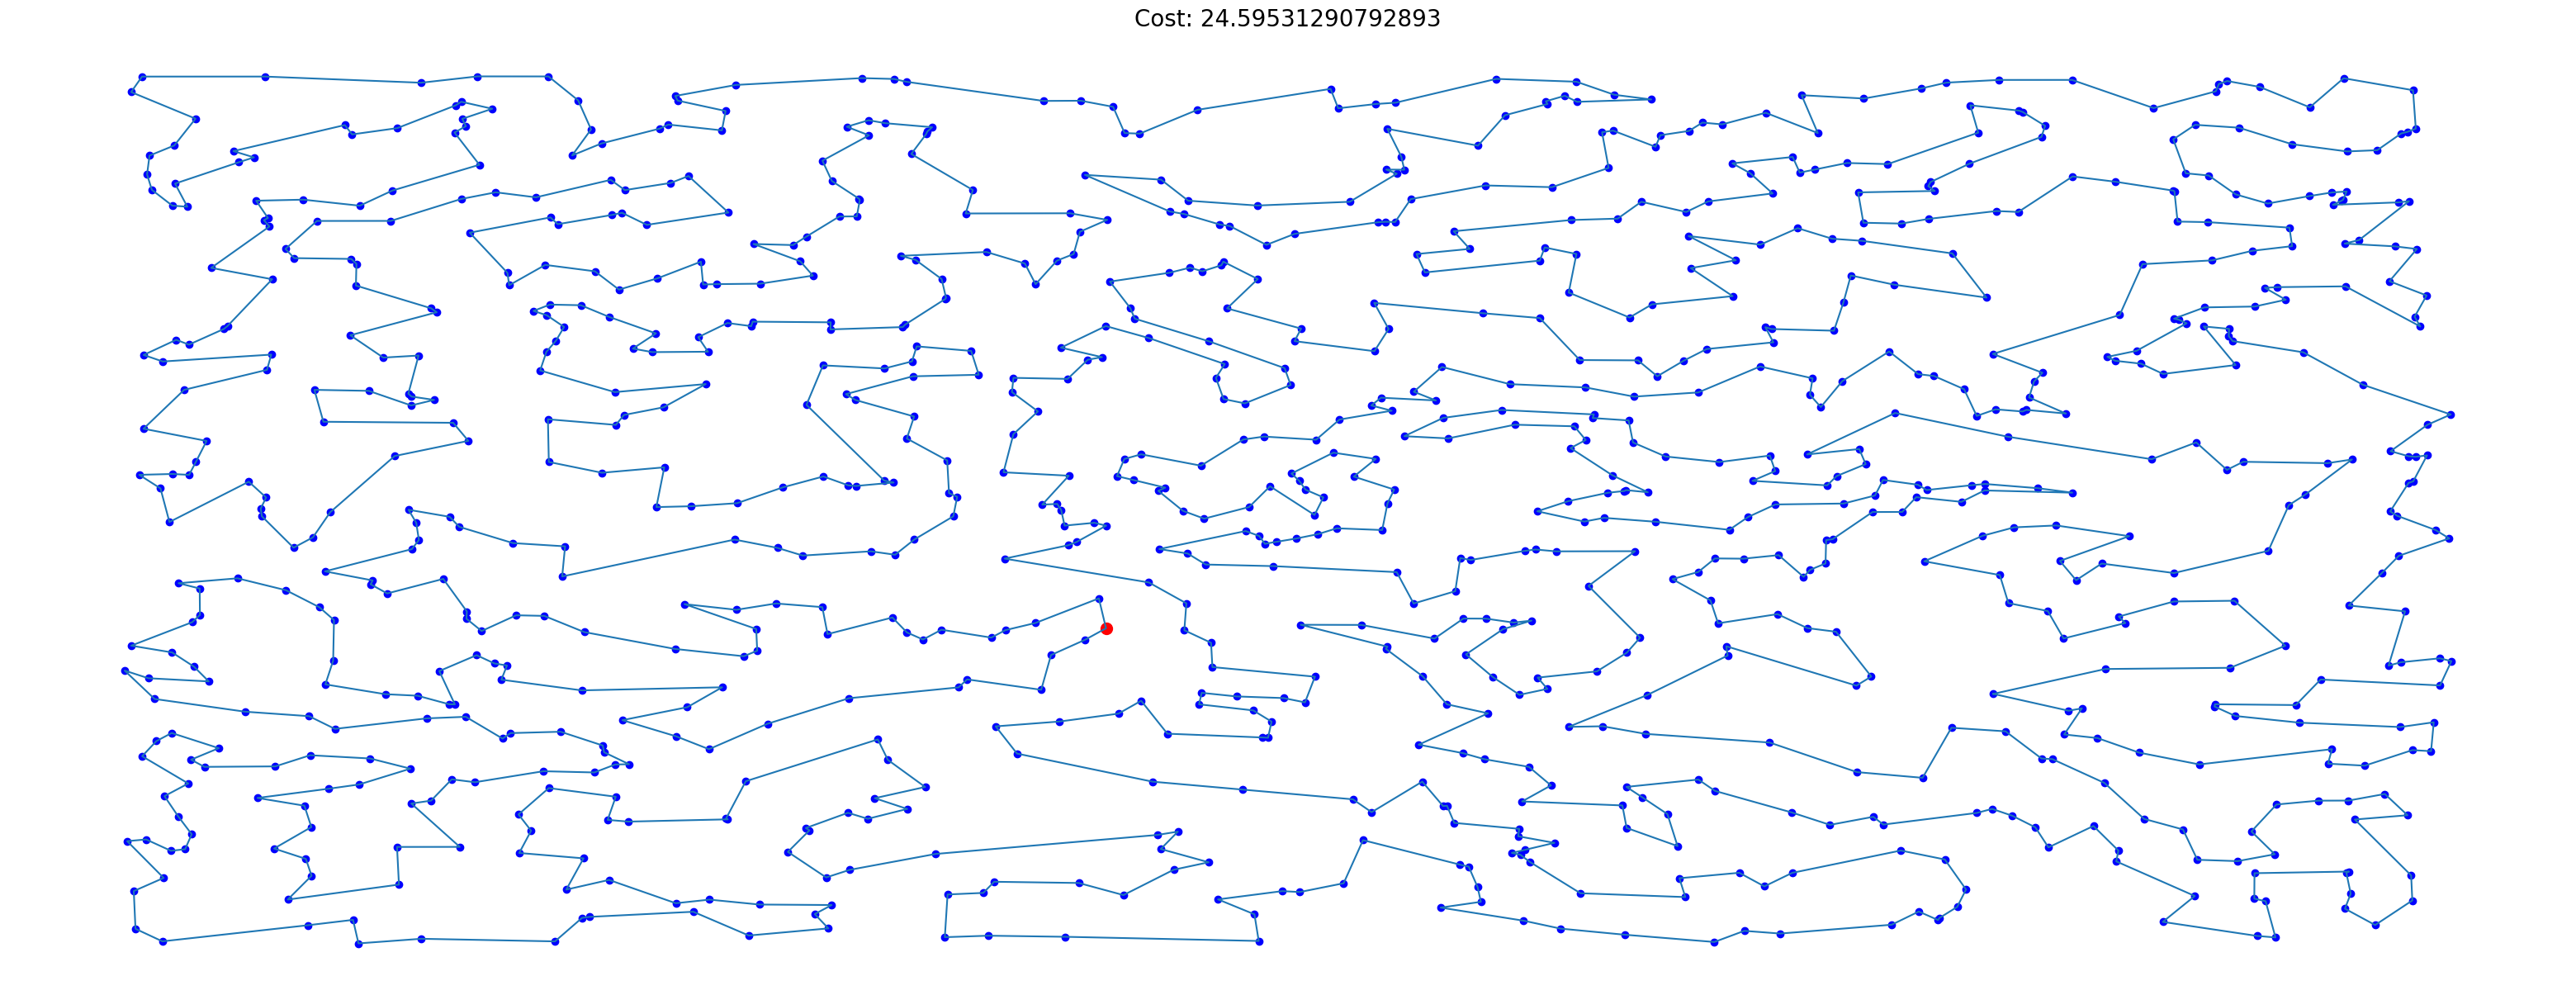

In [19]:
cost([935, 437, 749, 841, 261, 808, 340, 430, 999, 523, 169, 410, 278, 13, 479, 844,
 661, 22, 974, 790, 170, 333, 381, 694, 238, 308, 719, 37, 535, 882, 282, 899,
 846, 495, 310, 60, 106, 879, 412, 822, 415, 200, 645, 952, 35, 825, 750, 182,
 577, 836, 666, 390, 727, 146, 520, 81, 553, 306, 316, 229, 769, 570, 89, 839,
 720, 359, 730, 609, 132, 573, 496, 2, 441, 847, 58, 929, 541, 998, 811, 131,
 713, 800, 432, 447, 918, 175, 85, 416, 254, 113, 945, 649, 461, 700, 206, 703,
 418, 474, 116, 92, 895, 45, 641, 656, 90, 606, 192, 485, 417, 346, 959, 963,
 805, 201, 203, 70, 950, 857, 957, 955, 614, 855, 5, 242, 276, 670, 815, 268,
 231, 476, 401, 332, 736, 33, 728, 580, 408, 235, 884, 613, 189, 706, 127, 838,
 153, 105, 566, 54, 733, 878, 759, 981, 202, 68, 460, 773, 328, 250, 128, 659,
 791, 385, 545, 279, 775, 557, 894, 801, 660, 311, 678, 876, 228, 211, 906, 405,
 970, 651, 767, 154, 531, 309, 751, 246, 910, 526, 804, 223, 509, 24, 458, 684,
 140, 497, 42, 17, 875, 133, 469, 856, 147, 826, 917, 527, 467, 249, 540, 252,
 302, 966, 66, 464, 637, 215, 187, 725, 366, 120, 755, 968, 819, 973, 897, 587,
 329, 560, 135, 177, 369, 539, 816, 665, 260, 596, 298, 701, 285, 698, 758, 375,
 38, 675, 590, 304, 770, 986, 373, 711, 984, 617, 327, 834, 930, 29, 137, 578,
 828, 831, 756, 53, 598, 149, 88, 353, 23, 323, 351, 537, 561, 256, 414, 293,
 997, 799, 46, 887, 715, 472, 442, 611, 136, 567, 433, 699, 595, 881, 314, 623,
 607, 48, 34, 292, 494, 626, 741, 723, 358, 599, 325, 516, 243, 873, 774, 445,
 15, 275, 830, 59, 109, 500, 295, 318, 121, 478, 324, 538, 94, 795, 434, 221,
 905, 752, 117, 387, 317, 466, 793, 653, 435, 376, 603, 867, 877, 635, 874, 259,
 612, 199, 823, 7, 919, 157, 827, 468, 73, 180, 459, 809, 83, 95, 427, 721, 108,
 100, 49, 98, 714, 321, 1, 962, 900, 552, 807, 518, 69, 888, 97, 946, 220, 183,
 139, 746, 270, 916, 850, 643, 184, 50, 280, 640, 860, 234, 119, 20, 334, 718,
 716, 129, 763, 299, 768, 889, 925, 294, 842, 80, 832, 164, 549, 554, 383, 161,
 134, 65, 824, 534, 883, 429, 419, 692, 423, 152, 236, 262, 167, 657, 636, 297,
 355, 673, 112, 944, 593, 940, 273, 289, 938, 584, 896, 861, 43, 156, 398, 941,
 399, 388, 533, 377, 18, 818, 104, 263, 47, 650, 148, 871, 858, 145, 449, 44,
 477, 320, 428, 426, 266, 992, 452, 287, 382, 797, 515, 592, 28, 64, 658, 833,
 542, 62, 528, 26, 96, 291, 126, 608, 829, 512, 866, 947, 597, 638, 789, 912,
 245, 740, 102, 141, 550, 142, 870, 628, 214, 686, 354, 961, 372, 536, 3, 386,
 708, 757, 384, 621, 913, 123, 455, 891, 994, 565, 705, 473, 788, 87, 982, 296,
 207, 303, 662, 744, 765, 14, 176, 225, 86, 574, 863, 82, 642, 616, 620, 491,
 12, 465, 814, 644, 633, 363, 901, 335, 794, 802, 942, 480, 151, 697, 843, 403,
 357, 958, 548, 880, 470, 738, 422, 971, 394, 338, 406, 389, 222, 601, 51, 954,
 764, 975, 420, 687, 953, 546, 576, 247, 486, 76, 726, 277, 712, 453, 530, 792,
 462, 707, 555, 737, 288, 655, 111, 367, 639, 446, 343, 74, 337, 0, 407, 251,
 931, 813, 648, 904, 951, 269, 8, 191, 575, 374, 162, 284, 36, 762, 859, 558,
 271, 493, 158, 312, 724, 371, 786, 781, 849, 996, 572, 780, 281, 166, 798, 489,
 352, 517, 326, 11, 421, 852, 144, 568, 448, 605, 32, 272, 244, 976, 872, 101,
 300, 652, 690, 274, 821, 209, 890, 72, 216, 488, 431, 564, 315, 178, 21, 443,
 948, 507, 936, 785, 138, 779, 771, 444, 806, 19, 631, 173, 583, 654, 103, 602,
 934, 862, 454, 920, 283, 810, 524, 532, 71, 77, 91, 484, 193, 748, 349, 893,
 230, 93, 956, 6, 350, 760, 165, 544, 969, 600, 693, 559, 286, 195, 907, 402,
 965, 125, 204, 571, 688, 218, 990, 664, 395, 709, 983, 257, 198, 668, 502, 682,
 569, 911, 853, 915, 110, 745, 820, 663, 425, 624, 949, 159, 679, 729, 625, 892,
 747, 926, 451, 922, 475, 171, 78, 63, 155, 627, 40, 409, 368, 233, 845, 672,
 695, 909, 341, 347, 964, 927, 989, 290, 581, 143, 190, 185, 331, 39, 591, 618,
 610, 632, 197, 226, 977, 667, 739, 186, 232, 837, 481, 99, 995, 258, 364, 932,
 179, 196, 307, 753, 361, 365, 851, 505, 511, 543, 960, 979, 31, 194, 84, 130,
 150, 188, 924, 551, 778, 585, 107, 56, 835, 501, 61, 411, 772, 685, 397, 586,
 219, 898, 677, 742, 594, 522, 562, 629, 267, 499, 683, 237, 456, 487, 619, 122,
 342, 248, 993, 588, 463, 265, 305, 864, 985, 174, 510, 241, 782, 30, 939, 921,
 205, 978, 902, 344, 796, 9, 181, 777, 776, 704, 556, 457, 503, 717, 393, 424,
 696, 471, 812, 980, 634, 380, 914, 513, 908, 734, 439, 370, 787, 754, 118, 413,
 240, 379, 676, 400, 25, 115, 669, 803, 301, 239, 604, 41, 743, 731, 438, 483,
 52, 490, 508, 114, 160, 589, 378, 212, 732, 163, 4, 57, 336, 937, 987, 865,
 885, 563, 339, 322, 710, 255, 988, 647, 391, 691, 208, 886, 689, 436, 75, 646,
 356, 482, 404, 392, 514, 264, 840, 319, 498, 525, 671, 903, 547, 224, 330, 213,
 348, 783, 615, 967, 396, 869, 313, 27, 521, 79, 506, 766, 55, 217, 972, 702,
 680, 868, 450, 440, 253, 817, 124, 848, 360, 210, 168, 16, 227, 784, 172, 943,
 492, 761, 504, 10, 735, 622, 579, 345, 923, 519, 722, 681, 630, 529, 933, 991,
 854, 582, 928, 674, 362, 67])

## k-opt heuristic, Python (~24.78)

Sources:
- https://github.com/ngamanda/Kattis-TSP/blob/master/main.cpp
- https://github.com/Lookuz/CS4234-Stochastic-Local-Search-Methods/tree/master/TSP

In [69]:
def _4_opt(tour):
    '''
    Performs a random 4-opt ("double bridge") move on a tour.
    e.g.

      A--B             A  B
     /    \           /|  |\
    H      C         H------C
    |      |   -->     |  |
    G      D         G------D
     \    /           \|  |/
      F--E             F  E
    
    where edges AB, CD, EF and GH are chosen randomly.
    '''
    a = randint(1, N//4)
    b = a + randint(1, N//4)
    c = b + randint(1, N//4)
    tour = tour[:a] + tour[c:] + tour[b:c] + tour[a:b]
    #print('4-opt: Cost is now', cost(tour, plot=False))
    return tour

def _2_opt(tour, asp_ratio, tabu_tenure, niter=5):
    def _2_opt_swap(tour, i, k):
        return tour[:i] + tour[i:k+1][::-1] + tour[k+1:]

    def decrement_tabu():
        k = N//2
        for i in range(k):
            for j in range(k):
                if tabu_list[i][j] > 0: tabu_list[i][j] = tabu_list[j][i] = tabu_list[i][j] - 1

    tabu_list.fill(0)
    original_tour = local_opt_tour = list(tour)
    original_cost = local_opt_cost = cost(tour, plot=False)
    best_cost, tour = original_cost, original_tour
    for iter in range(niter):
        is_local_opt = False
        #best_cost, tour = original_cost, original_tour
        while not is_local_opt:
            is_local_opt = True
            for i in range(N):
                for k in range(i+1, N-1):
                    iB = N-1 if i == 0 else i-1
                    kA = 0 if k == N-1 else k+1
                    new_cost = best_cost - G[tour[i]][tour[iB]] - G[tour[k]][tour[kA]] + G[tour[iB]][tour[k]] + G[tour[i]][tour[kA]]
                    if (new_cost < best_cost and tabu_list[i][k] == 0) or new_cost * asp_ratio < best_cost:
                        tour = _2_opt_swap(tour, i, k)
                        best_cost = new_cost
                        is_local_opt = False
                        tabu_list[i][k] = tabu_tenure
            decrement_tabu()
            #if not is_local_opt: print('2-opt: Found a better cost(?) of', best_cost)
        if best_cost < local_opt_cost:
            local_opt_tour = tour
            local_opt_cost = best_cost
    return local_opt_tour

def _2half_opt(tour):
    can_improve = True
    while can_improve:
        can_improve = False
        for i in range(N-2):
            for j in range(i+3, N-1):
                a, b, c, d, e = tour[i], tour[i+1], tour[i+2], tour[j], tour[j+1]
                if G[a][c] + G[d][b] + G[b][e] < G[a][b] + G[b][c] + G[d][e]:
                    can_improve = True
                    tour = tour[:i+1] + tour[i+2:j+1] + [tour[i+1]] + tour[j+1:]
        #if can_improve: print('2.5-opt: Found a better cost(?) of', cost(tour, plot=False))
    return tour

def _3_opt(tour):
    can_improve = True
    best_cost = cost(tour, plot=False)
    while can_improve:
        can_improve = False
        for i in range(1, N):
            for j in range(i+1, N):
                rem = best_cost - (G[tour[i]][tour[i-1]] + G[tour[j]][tour[j-1]] + G[tour[N-1]][tour[0]])
                t1_cost = rem + G[tour[i-1]][tour[j]] + G[tour[N-1]][tour[i]] + G[tour[j-1]][tour[0]]
                t2_cost = rem + G[tour[i-1]][tour[j-1]] + G[tour[N-1]][tour[i]] + G[tour[j]][tour[0]]
                if t1_cost < min(t2_cost, best_cost) - 5e-8:
                    can_improve = True
                    best_cost = t1_cost
                    tour = tour[:i] + tour[j:] + tour[i:j]
                elif t2_cost < min(t1_cost, best_cost) - 5e-8:
                    can_improve = True
                    best_cost = t2_cost
                    tour = tour[:i] + tour[i:j][::-1] + tour[j:][::-1]
        #if can_improve: print('3-opt: Found a better cost(?) of', best_cost)
    return tour

In [70]:
def tsp_k_opt(G):
    tour = tsp_greedy(G) # start with a good-enough tour
    tabu_list = onp.zeros(shape=(N, N))
    best_tour, best_cost = tour, cost(tour, plot=False)
    for iter in tqdm(range(10)):
        tour = _4_opt(tour)
        tour = _2_opt(tour, asp_ratio=15, tabu_tenure=5)
        tour = _2half_opt(tour)
        tour = _3_opt(tour)
        c = cost(tour, plot=False)
        print(f'Iteration {iter}: {c}')
        if c < best_cost: best_tour, best_cost = tour, c
    return best_tour

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 0: 24.95065018401539
Iteration 1: 24.86541118791119
Iteration 2: 24.997736943520106
Iteration 3: 24.779937413053755
Iteration 4: 25.04596818331733
Iteration 5: 24.859620832488954
Iteration 6: 25.10659531149732
Iteration 7: 25.048318652491435
Iteration 8: 24.963222318697085
Iteration 9: 25.062180104660456


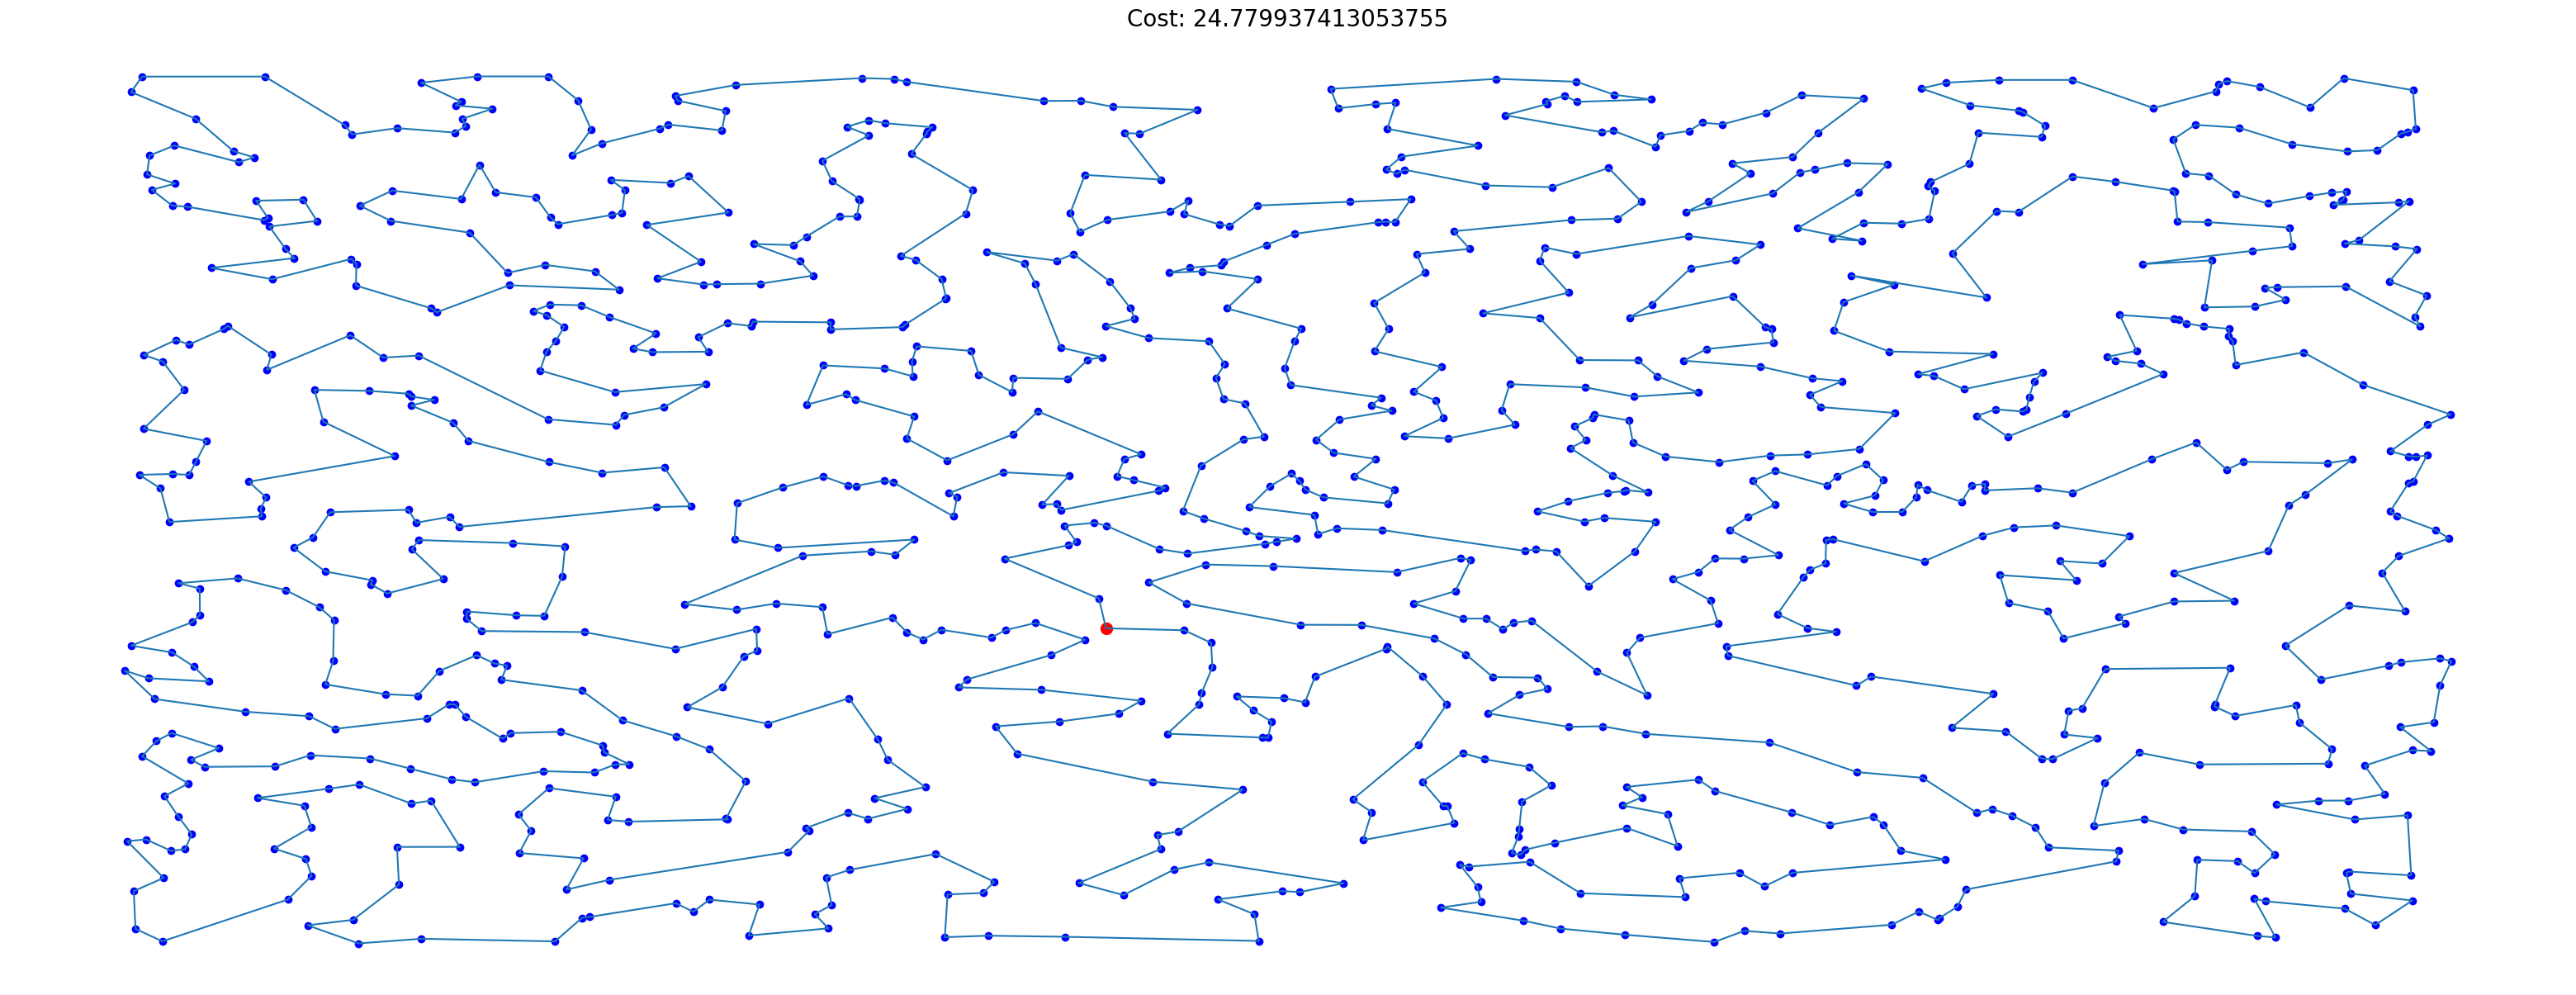

In [71]:
cost(tsp_k_opt(G))

## Ant Colony Optimization (~29.3)

Source: https://github.com/ppoffice/ant-colony-tsp

How it works: https://github.com/yammadev/aco-tsp/blob/master/aco-tsp.ipynb

In [72]:
class ACOGraph(object):
    def __init__(self, adjacency_matrix):
        self.matrix = adjacency_matrix
        rank = len(adjacency_matrix)
        self.rank = rank
        self.pheromone = onp.full(shape=(rank, rank), fill_value=1/(rank**2))

class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int, strategy: int):
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy
        assert strategy in [*range(3)]

    def _update_pheromone(self, graph: ACOGraph, ants: list):
        graph.pheromone *= (1-self.rho)
        for ant in ants: graph.pheromone += ant.pheromone_delta

    def solve(self, graph: ACOGraph):
        best_cost = float('inf')
        best_solution = []
        for gen in tqdm(range(self.generations)):
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            if gen % 10 == 0: print(f'Generation {gen}: {best_cost}')
        return best_solution


class _Ant(object):
    def __init__(self, aco: ACO, graph: ACOGraph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []
        self.pheromone_delta = []
        self.allowed = set(range(graph.rank))
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]
        start = randint(0, graph.rank - 1)
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        probabilities = [0]*self.graph.rank
        for i in self.allowed:
            probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha + self.eta[self.current][i] ** self.colony.beta
        denom = sum(probabilities)
        for i in self.allowed:
            probabilities[i] /= denom
        selected = 0
        rand = random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    def _update_pheromone_delta(self):
        self.pheromone_delta = onp.zeros(shape=(self.graph.rank, self.graph.rank))
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [73]:
def tsp_aco(G):
    aco = ACO(ant_count=8, generations=101, alpha=1.0, beta=9.0, rho=0.5, q=1, strategy=2)
    graph = ACOGraph(G)
    return aco.solve(graph) 

  0%|          | 0/101 [00:00<?, ?it/s]

Generation 0: 30.830703511013922
Generation 10: 30.196768242326204
Generation 20: 30.196768242326204
Generation 30: 29.31600085128294
Generation 40: 29.31600085128294
Generation 50: 29.31600085128294
Generation 60: 29.31600085128294
Generation 70: 29.31600085128294
Generation 80: 29.27644408869033
Generation 90: 29.27644408869033
Generation 100: 29.27644408869033


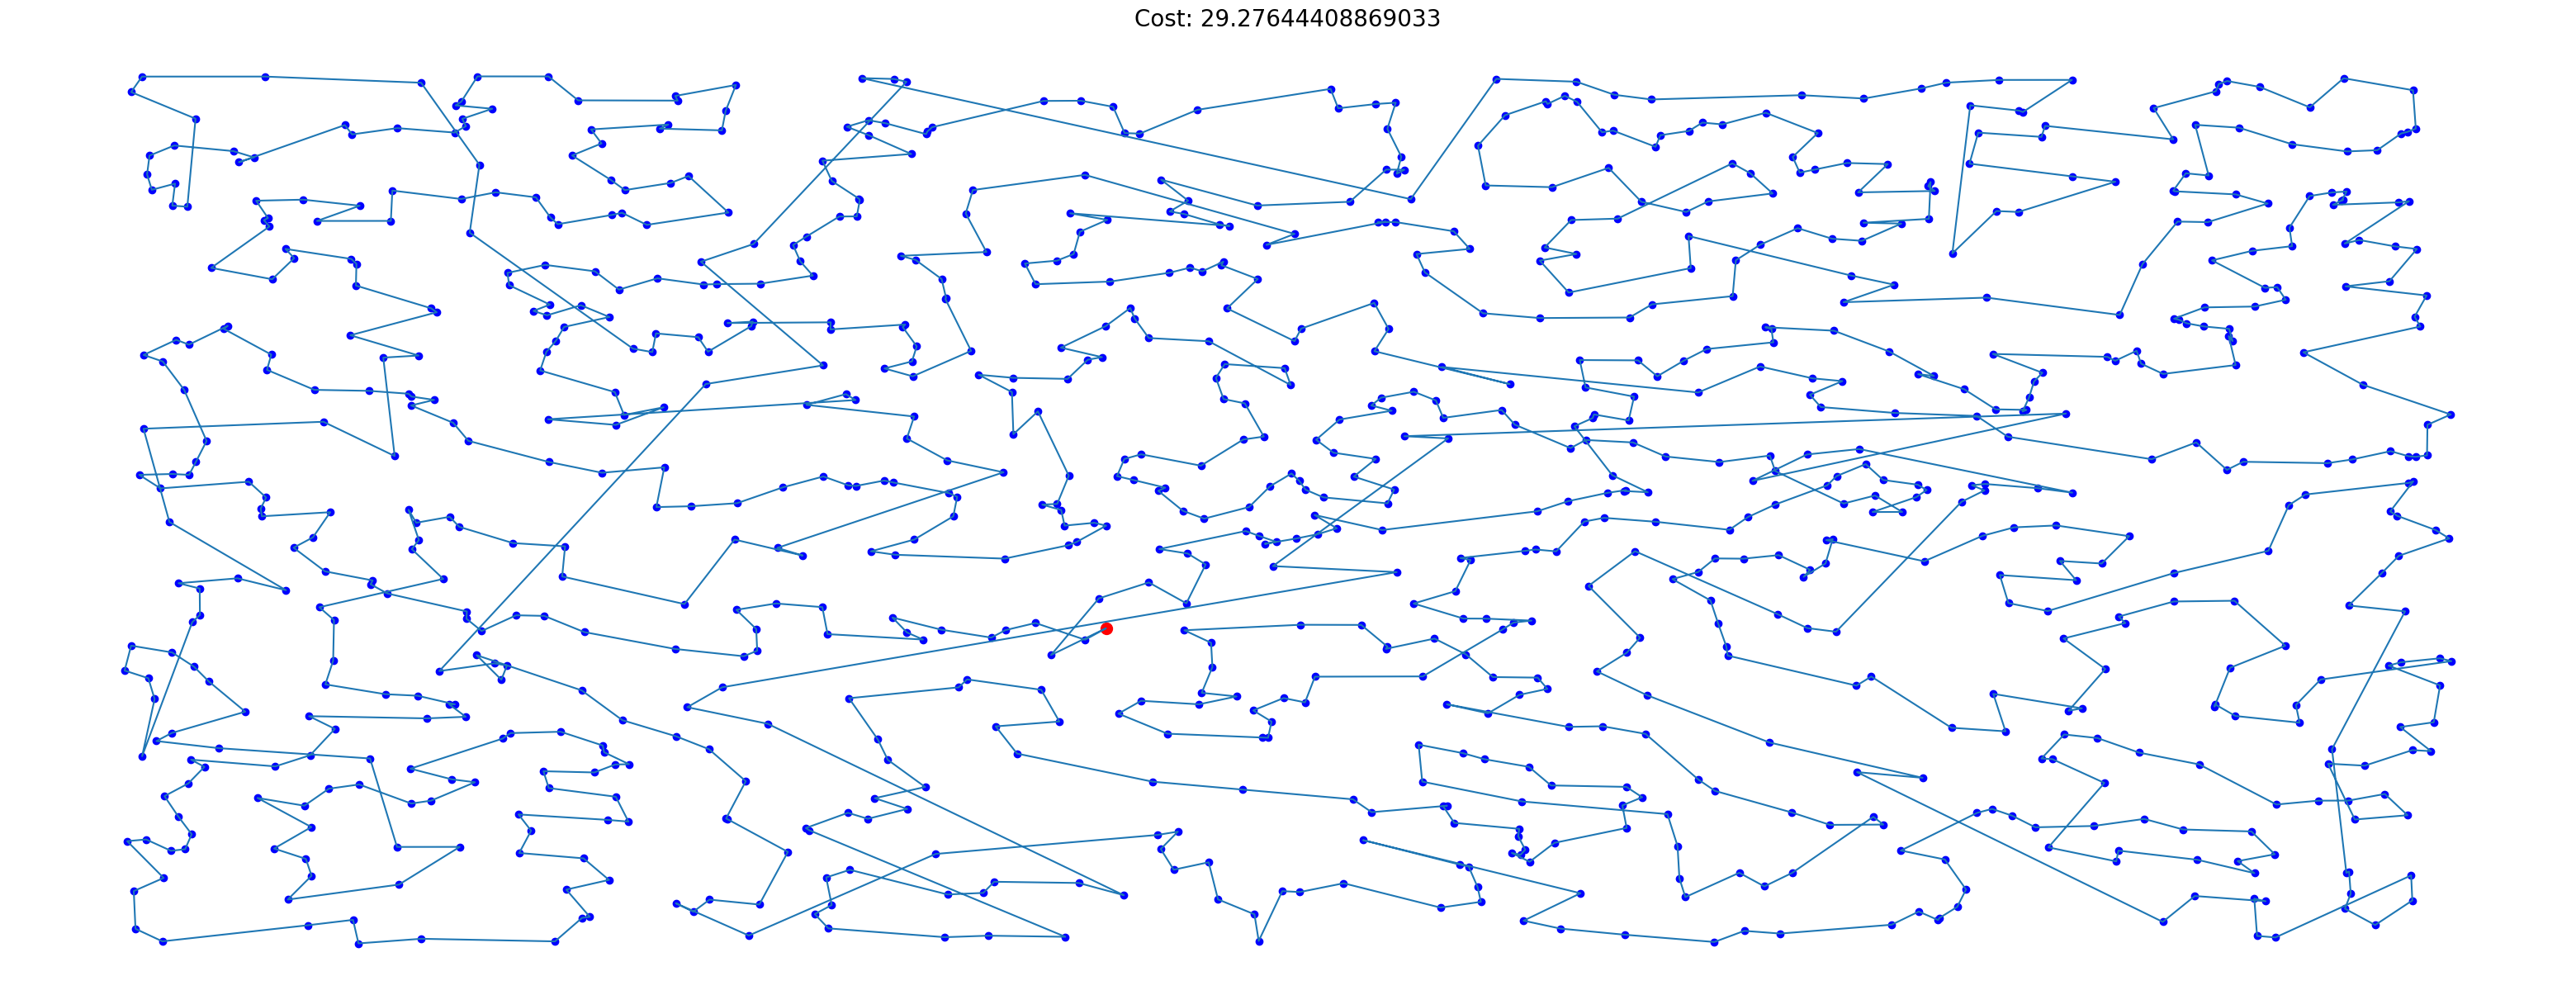

CPU times: user 23min 21s, sys: 11.5 s, total: 23min 33s
Wall time: 24min 26s


In [74]:
%%time
cost(tsp_aco(G))

## PyConcorde (23.32)

Source: https://github.com/jvkersch/pyconcorde

How it works: https://www.reddit.com/r/compsci/comments/8auwm9/how_does_concorde_claim_to_be_a_tsp_solver/

In [16]:
try:
    !git clone https://github.com/jvkersch/pyconcorde
except:
    pass

%cd pyconcorde

try:
    from concorde.tsp import TSPSolver
except:
    !pip install -e .
    from concorde.tsp import TSPSolver

fatal: destination path 'pyconcorde' already exists and is not an empty directory.
/content/drive/MyDrive/dataset/DSA4212/assignment_3/pyconcorde


In [17]:
# Approximate to an integer since every coordinate value is originally below 1
xs, ys = zip(*cities)
M = 1e7
xs, ys = [*map(lambda x: x*M, xs)], [*map(lambda y: y*M, ys)]

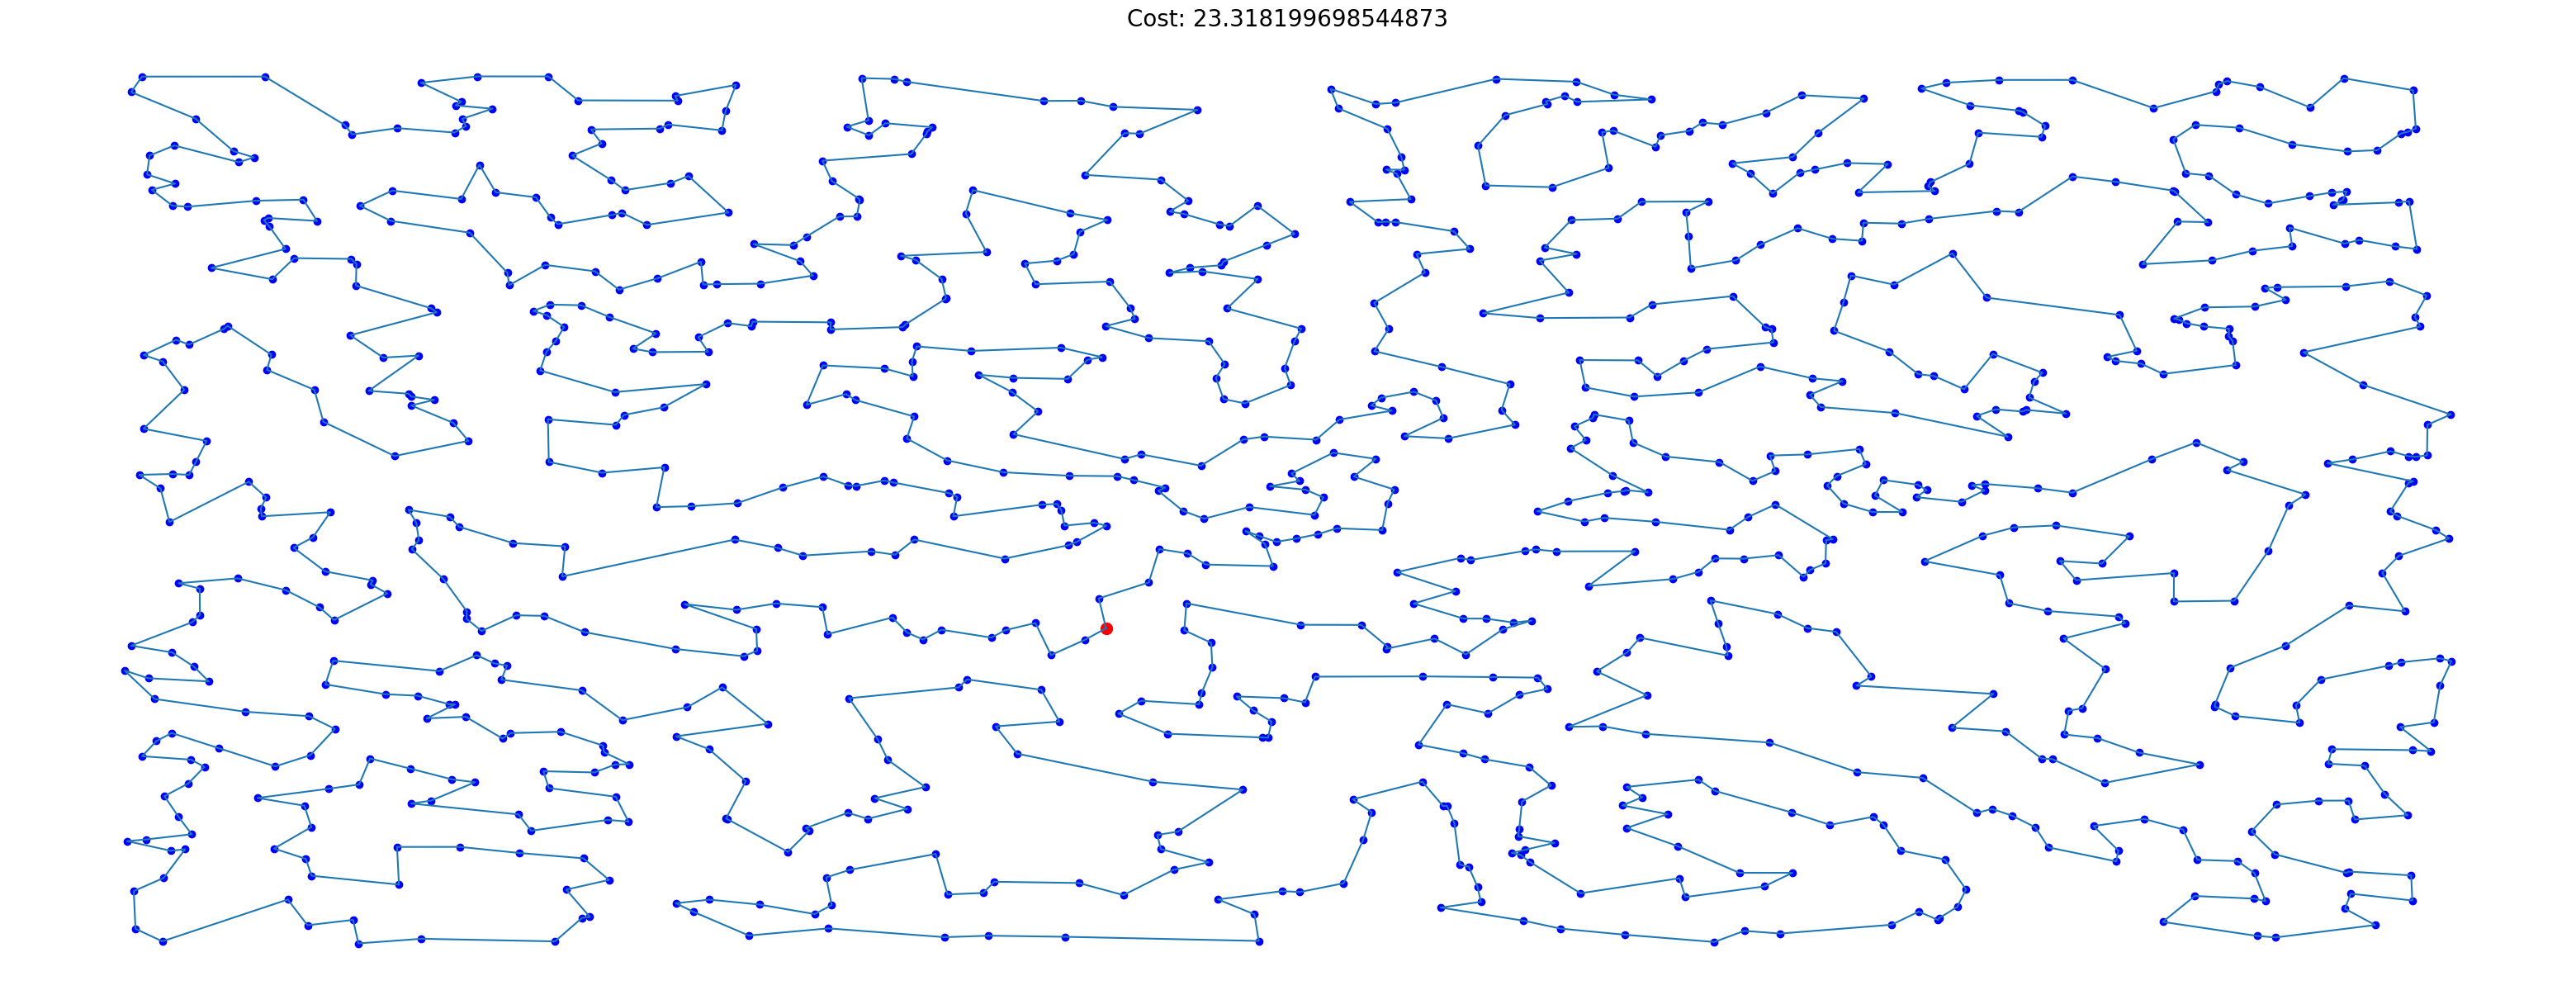

In [18]:
tsp_solver = TSPSolver.from_data(xs, ys, norm='EUC_2D', name='assignment_3')
tour, val, success, foundtour, hit_timebound = tsp_solver.solve()
assert success
assert foundtour
cost(tour)